# **MILESTONE 2 - PHASE 2**

Nama : Krisbiantoro Prabowo

Batch : 008
<hr>

## **1. Description**
### 1.1. Objective
Milestones 2 ini bertujuan untuk:

- Mengenal  dan menggali informasi mengenai pergerakan harga cryptocurrency khususnya pada bitcoin(BTC) terhadap usd(USDT)
- Mampu membuat model Neural Network(NN) yang dapat memprediksi harga BTC/USDT
- Model NN yang telah dibuat mampu memprediksi harga BTC/USDT dengan data yang baru saja masuk(inference)

### 1.2. About Dataset
Diberikan sebuah dataset berupa historical data dari pergerakan BTC terhadap USD. Kolom yang diberikan seperti pada umumnya memiliki informasi mengenai OHLC (Open, High, Low, Close) dan informasi lain yang berkaitan seperti tanggal dan jam terjadinya transaksi. Data Transaksi yang dicatat merupakan data tiap jam dan mulai direkam mulai dari 17 Agustus 2018

### 1.3. Problem Statement
Kita adalah seorang **day trader** dimana kita sering melakukan `Open Posisi/Trade` di hari yang sama. Oleh karena itu kita terbiasa menggunakan chart berbagai time frame salah satunya ialah 1 jam(perubahan harga tiap jamnya). Karena sering menggunakan time frame tersebut, kita ingin setidaknya mengetahui harga penutupan pada time frame 1 jam kedepannya. Dengan hal ini kita memiliki pandangan setidaknya dari prediksi yang dilakukan apakah harga bergerak naik, stagnan, atau justru turun. Diharapkan dengan mengetahui pergerakan ini, dapat membantu kita apakah kondisi harga pada saat itu nantinya ideal untuk dilakukan `Open Trade` dengan definisi rules atau aturan trading yang sudah kita tetapkan.

### 1.4. Useful Links
- Dataset: [here](https://www.kaggle.com/datasets/oscardavidperilla/historical-bitcoin-prices-btc)
- Colab: [here]()
- Heroku(deployment): [here](https://krisbiantoro-p2-m2.herokuapp.com/)
<hr>

## **2. Import Libraries**

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler,StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
import pickle
import tensorflow as tf
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping
from keras.layers import LSTM, Dense, Dropout, Activation, Flatten, GRU
from keras import optimizers
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import mplfinance as fplt

pd.options.mode.chained_assignment = None

In [2]:
colors = sns.color_palette("Set2")
colors2 = sns.color_palette("Paired")
sns.set_style("whitegrid")
plt.style.use('seaborn-pastel')
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings("ignore")
# import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

## **3. Data Loading**

### 3.1. Data Loading

In [3]:
df = pd.read_csv('historical_prices/BTCUSDT_1h_2021_2022.csv').set_index('Unnamed: 0')

In [4]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11
Unnamed: 0,,,,,,,,,,,,
0,1612137600000,33092.97,33106.33,32296.16,32546.27,4383.926122,1612141199999,1.427372e+08,98763,2074.600069,6.750233e+07,0
1,1612141200000,32546.32,33560.90,32476.34,33430.29,3713.649492,1612144799999,1.229016e+08,76863,1958.691774,6.482048e+07,0
2,1612144800000,33425.19,33830.00,33222.88,33649.73,3694.931629,1612148399999,1.241016e+08,70196,2026.270613,6.804863e+07,0
3,1612148400000,33646.37,33776.81,33470.00,33573.97,2882.141795,1612151999999,9.689886e+07,65467,1502.164716,5.050666e+07,0
4,1612152000000,33573.25,33943.55,33423.43,33558.25,3206.054328,1612155599999,1.079852e+08,82376,1739.632601,5.861244e+07,0


### 3.2. Rename Columns

In [5]:
df= df.rename(columns={'0': 'open_time', '1':'open', '2':'high', '3':'low', '4':'close', '5':'volume', '6': 'close_time', '7': 'quote_asset_volume', '8': 'number_of_trades', '9': 'taker_buy_asset_volume', '10': 'taker_buy_quote_asset_volume', '11': 'ignore'})

## **4. Exploratory Data Analysis**

### 4.1. Brief Information

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10169 entries, 0 to 10168
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   open_time                     10169 non-null  int64  
 1   open                          10169 non-null  float64
 2   high                          10169 non-null  float64
 3   low                           10169 non-null  float64
 4   close                         10169 non-null  float64
 5   volume                        10169 non-null  float64
 6   close_time                    10169 non-null  int64  
 7   quote_asset_volume            10169 non-null  float64
 8   number_of_trades              10169 non-null  int64  
 9   taker_buy_asset_volume        10169 non-null  float64
 10  taker_buy_quote_asset_volume  10169 non-null  float64
 11  ignore                        10169 non-null  int64  
dtypes: float64(8), int64(4)
memory usage: 1.0 MB


- Tidak ditemukannya missing value pada keseluruhan kolom, khususnya kolom yang akan kita gunakan yaitu `close`. Ini dapat memudahkan kita untuk mengolah data dan mempersiapkan data sebelum masuk ke Neural Network, karena dapat langsung menggunakan data secara utuh

In [7]:
num_columns = df.select_dtypes(include=np.number).columns.tolist()
cat_columns = df.select_dtypes(include=['object']).columns.tolist()

print('Numeric Columns: ', num_columns)
print('Categorical Columns: ', cat_columns)

Numeric Columns:  ['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_asset_volume', 'taker_buy_quote_asset_volume', 'ignore']
Categorical Columns:  []


- Karena data berisi informasi mengenai rekam transaksi BTC/USDT, wajar jika mayoritas kolom bertipe Numerik

### 4.2. Statistical Descriptive

In [8]:
df.describe()

,open_time,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_asset_volume,taker_buy_quote_asset_volume,ignore
count,1.016900e+04,10169.000000,10169.000000,10169.000000,10169.000000,10169.000000,1.016900e+04,1.016900e+04,10169.000000,10169.000000,1.016900e+04,10169.0
mean,1.630472e+12,46994.786758,47269.287659,46705.732727,46995.913827,2569.873315,1.630476e+12,1.181009e+08,68965.474875,1265.283757,5.817753e+07,0.0
std,1.058312e+10,8950.931672,8970.962023,8925.753846,8949.916235,2187.496579,1.058312e+10,9.463427e+07,45077.328052,1068.576295,4.650215e+07,0.0
min,1.612138e+12,29239.000000,29706.830000,28805.000000,29238.990000,0.000000,1.612141e+12,0.000000e+00,0.000000,0.000000,0.000000e+00,0.0
25%,1.621314e+12,39356.920000,39600.000000,39078.500000,39357.030000,1308.592197,1.621318e+12,6.066155e+07,39820.000000,642.922300,2.942543e+07,0.0
50%,1.630480e+12,46833.480000,47096.960000,46543.000000,46833.480000,1991.740782,1.630483e+12,9.395321e+07,57615.000000,981.935259,4.627915e+07,0.0
75%,1.639638e+12,54874.670000,55195.840000,54517.010000,54875.620000,3083.940840,1.639642e+12,1.453238e+08,84501.000000,1527.092198,7.145319e+07,0.0
max,1.648789e+12,68635.120000,69000.000000,68451.190000,68633.690000,44239.811778,1.648793e+12,1.514465e+09,799206.000000,19904.321262,6.849674e+08,0.0


- Keseluruhan kolom khususnya pada kolom close tampaknya memiliki `outlier` dan memiliki pendistribusian data bersifat `skewed` jika dilihat dari gap atau selisih yang dihasilkan dari posisi Quartile 3 ke Quartile 4(Max)
- Dengan mengetahui bahwa harga cryptocurrency termasuk BTC sangatlah volatile (kenaikan ataupun turunnya harga memiliki rentang yang tinggi ), khususnya jika terdapat news yang memberikan dampak signifikan entah itu berita yang baik ataupun yang buruk pada interval waktu saat itu. Maka besar kemungkinan kolom akan memiliki outlier dan memiliki nilai varians/std yang juga tinggi. Namun outlier tersebut akan kita biarkan dan tidak ditangani sama sekali
- Hal ini dikarenakan kita membutuhkan informasi rentang tersebut dan oleh karena itu, untuk setidaknya memudahkan komputasi pada deep learning. Kita akan menormalisasi data harga pada kolom close dengan teknik `MinMaxScaler` dengan mengubah nilainya menjadi rentang dari 0 hingga 1

In [9]:
skewness = pd.DataFrame({'columns':df.describe().columns, 'skew' : df.skew(axis=0)})
skewness.reset_index(drop=True, inplace=True)
skewness['status'] = np.where(skewness['skew'].abs()>0.5, 'Skewed', 'Normal')
skewness

,columns,skew,status
0,open_time,-0.001193,Normal
1,open,0.201053,Normal
2,high,0.199509,Normal
3,low,0.202436,Normal
4,close,0.201096,Normal
5,volume,4.627426,Skewed
6,close_time,-0.001193,Normal
7,quote_asset_volume,3.796731,Skewed
8,number_of_trades,3.512922,Skewed
9,taker_buy_asset_volume,4.231173,Skewed


- Ternyata benar jika keseluruhan kolom memiliki status `skewed` khususnya pada kolom close

### 4.3. Columns Analysis

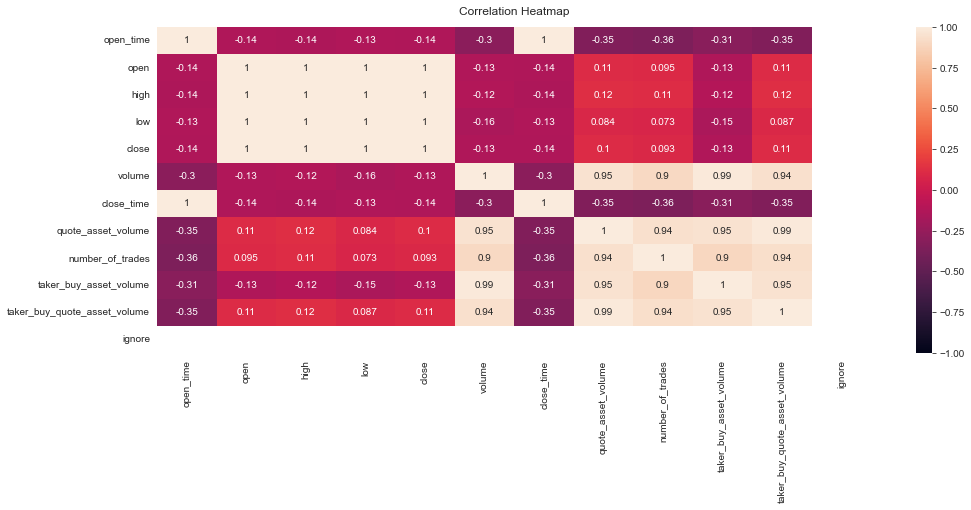

In [10]:
# Increase the size of the heatmap.
plt.figure(figsize=(16, 6))

heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

- Kolom OHLC, memiliki relasi yang sama sama kuat (bernilai 1). Hal ini wajar karena memang pada kolom-kolom ini mencatat rekam informasi harga tiap jamnya dan saling berhubungan dengan data-data sebelumnya

In [11]:
df_cor=df.corr()
for i in df_cor:
    j=0
    df_cor[i] = np.where(df_cor[i].abs()>0.1, df_cor[i], 'low')

In [12]:
for i in df_cor:
    print(f'Column: {i}')
    low_corr = df_cor[i][(df_cor[i] == "low")].value_counts().tolist()
    if low_corr:
        print('low:',low_corr)
    else:
        print('low:',0)
    print("="*20)

Column: open_time
low: [1]
Column: open
low: [2]
Column: high
low: [1]
Column: low
low: [4]
Column: close
low: [2]
Column: volume
low: [1]
Column: close_time
low: [1]
Column: quote_asset_volume
low: [2]
Column: number_of_trades
low: [4]
Column: taker_buy_asset_volume
low: [1]
Column: taker_buy_quote_asset_volume
low: [2]
Column: ignore
low: [12]


- Tidak ditemukannya korelasi yang bernilai rendah (dibawah 0.1) antar tia-tiap kolom

### 4.4. Gather Some Information

### 4.4.1. Historical Bitcoin Prices

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10169 entries, 0 to 10168
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   open_time                     10169 non-null  int64  
 1   open                          10169 non-null  float64
 2   high                          10169 non-null  float64
 3   low                           10169 non-null  float64
 4   close                         10169 non-null  float64
 5   volume                        10169 non-null  float64
 6   close_time                    10169 non-null  int64  
 7   quote_asset_volume            10169 non-null  float64
 8   number_of_trades              10169 non-null  int64  
 9   taker_buy_asset_volume        10169 non-null  float64
 10  taker_buy_quote_asset_volume  10169 non-null  float64
 11  ignore                        10169 non-null  int64  
dtypes: float64(8), int64(4)
memory usage: 1.0 MB


- Banyak hal yang terjadi pada fase ini. Project-project cryptocurrency yang sebelumnya dikembangkan, sudah banyak pada tahap `live` dan siap untuk digunakan oleh khalayak umum. Cara trading baru seperti Liquid Swap mulai populer dan banyak dilakukan, Pengenalan dan pengimplementasian Decentralized Finance atau biasa disingkat dengan `DeFi` juga terlaksana dalam kurun waktu interval ini. Dan salah satu berita yang terkenal ialah perusahaan milik `Elon Musk` yaitu tesla menerbitkan laporan keuangan dimana mereka menginvestasikan sebagian dana mereka kedalam bitcoin (berita dapat dilihat [disini](https://www.cnbc.com/2021/02/08/tesla-buys-1point5-billion-in-bitcoin.html))

### 4.4.3. Finding The Best Time Step/Sequence Length

- Karena kita seorang day trader dan sering melihat pergerakan harga berdasarkan time frame per 1 jam, maka hendaknya kita mencari informasi terlebih dahulu salah satu teknikal analisis yang umum digunakan dan berapa panjang interval yang ideal untuk teknikal analisis tersebut.
- Salah satu yang kita gunakan ialah `Moving Average(MA)`, dan didapat informasi (dari [artikel ini](https://www.investopedia.com/articles/active-trading/010116/perfect-moving-averages-day-trading.asp#:~:text=Moving%20averages%20add%20reliability%20to,the%20long%20and%20short%20sides.))bahwa timeframe yang umum digunakan ialah 5, 8, dan 13.
- Selain interval yang cenderung pendek tersebut, Moving Average sebesar 50 juga cocok khususnya pada trading berjangka menengah ([artikel terkait](https://tradeciety.com/how-to-use-moving-averages/)). Maka kita akan coba membandingkan Moving Average ini khususnya 50 dengan interval yang lebih pendek
- Dari sini, kita menetapkan bahwa `Time Step` yang digunakan mayoritas model **adalah** `5` dan membandingkan salah satunya dengan time step yang lebih panjangan yaitu `505

## **5. Data Preprocessing**

In [14]:
# df = pd.to_datetime(df,unit='ms')

### 5.1. Split Dataset

In [15]:
# Split data into train and test

train_data_length = len(df) - 168

data_train = df.iloc[:train_data_length]
X_test = df.iloc[train_data_length:]

In [16]:
# Split train set into train and validation

train_data_length = math.ceil(data_train.shape[0] * 0.9)

X_train = data_train.iloc[:train_data_length]
X_val = data_train.iloc[train_data_length:]

### 5.2. Feature Selection

- Karena kita hanya memprediksi harga penutupan tiap data `time series`-nya, maka kita hanya akan memilih kolom close

In [17]:
X_train_selected = X_train.loc[:, 'close']
X_val_selected = X_val.loc[:, 'close']
X_test_selected = X_test.loc[:, 'close']

### 5.3. Checking Outliers

- Meskipun kita tidak akan menghapus outlier yang ditemukan, karena kita membutuhkan informasi rentang yang dihasilkan dari tiap-tiap pergerakan harga. It's a good habit untuk sekedar check batas maksimum data sebelum dianggap outlier dan berapa persentasenya

In [18]:
preprocess_handling = pd.DataFrame({'columns' : [], 'skew' :[]})
preprocess_handling.loc[0] = ['close', X_train_selected.skew(axis=0)]
preprocess_handling.reset_index(drop=True, inplace=True)

preprocess_handling['status'] = np.where(preprocess_handling['skew'].abs()>0.5, 'Skewed', 'Normal')

In [19]:
    
# Since it's skewed, we are using IQR to handle outliers

def find_skewed_boundaries(df, distance):
  IQR = df.quantile(0.75) - df.quantile(0.25)

  lower = df.quantile(0.25) - distance * IQR
  upper = df.quantile(0.75) + distance * IQR

  return upper, lower

In [20]:

outliers={}
upper_boundary, lower_boundary = find_skewed_boundaries(X_train_selected, 3)
print(f"Batas lower dan upper untuk close:{lower_boundary, upper_boundary}")
outliers[f"outliers{j}"] = np.where(X_train_selected > upper_boundary, True, np.where(X_train_selected < lower_boundary, True, False))


Batas lower dan upper untuk close:(-8427.449999999983, 104308.38999999998)


In [21]:
for i, (k, v) in enumerate(outliers.items()):
    X_train_trimmed_sim = X_train.loc[~outliers[k]]
    preprocess_handling.loc[i,'trimmed_row'] = X_train.shape[0] - X_train_trimmed_sim.shape[0]
    preprocess_handling.loc[i,'percentage'] = np.round(100-(X_train_trimmed_sim.shape[0]/X_train.shape[0]*100), 2)

preprocess_handling

,columns,skew,status,trimmed_row,percentage
0,close,0.019304,Normal,0.0,0.0


- Terlihat persentase outlier pada kolom close, kurang lebih berkisat 14.66%

### 5.4. Feature Scaling

- Seperti yang telah dijelaskan sebelumnya pada tahap EDA, kita akan menggunakan teknik MinMaxScaler

In [22]:
scaler = RobustScaler()
scaler.fit(X_train_selected.values.reshape(-1, 1))

X_train_scaled = scaler.transform(X_train_selected.values.reshape(-1, 1))
X_val_scaled = scaler.transform(X_val_selected.values.reshape(-1, 1))
X_test_scaled = scaler.transform(X_test_selected.values.reshape(-1, 1))

### 5.5. Feature Extraction

- Karena data yang akan kita olah bersifat sequence, dimana antara satu informasi memiliki keterkaitan dengan informasi selanjutnya. Maka kita akan mengubah bentuk data, yang pada awalnya tersimpan tiap baris secara independent. Akan dihubungkan satu sama lain hingga mencapai 5 kolom dan kolom selanjutnya(ke 6 pada kasus ini) dijadikan sebagai label atau target yang akan diprediksi

In [23]:
sequence_length = 5

def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]

    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) 
        y.append(data[i, 0]) 
    
    x = np.array(x)
    y = np.array(y)
    return x, y

In [24]:
X_train_final, y_train = partition_dataset(sequence_length, X_train_scaled)
X_val_final, y_val = partition_dataset(sequence_length, X_val_scaled)
X_test_final, y_test = partition_dataset(sequence_length, X_test_scaled)


In [25]:
X_train_scaled.shape

(9001, 1)

In [26]:
print(f"Nilai X train pada index ke 5 sebelum ekstraksi :{X_train_scaled[5]}")
print(f"Nilai X Train index ke 1 setelah ekstraksi:{X_train_final[1][sequence_length-1][0]}")
print(f"Nilai y Train pada index ke 0 :{y_train[0]}")

Nilai X train pada index ke 5 sebelum ekstraksi :[-0.86392526]
Nilai X Train index ke 1 setelah ekstraksi:-0.863925261035
Nilai y Train pada index ke 0 :-0.863925261035


### 5.6 Preprocessing Input Layer

- Untuk menggunakan pipeline pada dataset, akan dibentuk menjadi data tensor, oleh karena itu kita menggunakan preprocessing input layer pada tensorflow, dimana data-data kita akan dipecah dan dikelompokkan satu sama lain sebelum masuk tahap training model Neural Network

In [27]:
import tensorflow as tf

#Train Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_final, y_train)).batch(128)

#Validation Dataset
val_dataset = tf.data.Dataset.from_tensor_slices((X_val_final, y_val)).batch(128)

#Test Dataset
# test_dataset = tf.data.Dataset.from_tensor_slices((X_test_final, y_test)).batch(64)

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-04-03 23:17:29.796796: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-03 23:17:29.799202: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## **6. Model Definition**

In [28]:
base_model = Sequential()

n_neurons = X_train_final.shape[1] * X_train_final.shape[2]
print('timesteps: ' + str(X_train_final.shape[1]) + ',' + ' features: ' + str(X_train_final.shape[2]) + ', neurons: ' + str(n_neurons))

# Model

base_model.add(layers.SimpleRNN(5, return_sequences=True, input_shape=(X_train_final.shape[1], X_train_final.shape[2])))
base_model.add(layers.SimpleRNN(2, return_sequences=True))
base_model.add(layers.SimpleRNN(1))
 
# Hyperparameters
optimizer='adam'; loss='mean_squared_error'; epochs = 30; batch_size = 128; patience = 6;

base_model.compile(optimizer=optimizer, loss=loss, metrics=['mean_squared_error'])

# early_stop = EarlyStopping(monitor='loss', 
#                            patience=patience, 
#                            verbose=0)

base_model.summary()

timesteps: 5, features: 1, neurons: 5
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 5, 5)              35        
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 5, 2)              16        
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 1)                 4         
                                                                 
Total params: 55
Trainable params: 55
Non-trainable params: 0
_________________________________________________________________


## **7. Model Training**

In [29]:
parameter_list = ['epochs: ' + str(epochs), 'batch_size: ' + str(batch_size), 'patience: ' + str(patience), 'optimizer: ' + str(optimizer), 'loss: ' + str(loss)]
print('Parameters: ' + str(parameter_list))

Parameters: ['epochs: 30', 'batch_size: 128', 'patience: 6', 'optimizer: adam', 'loss: mean_squared_error']


In [30]:
base_model_hist = base_model.fit(
                    train_dataset,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=val_dataset,
                    verbose=0
                )

2022-04-03 23:17:31.786248: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-04-03 23:17:31.796330: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-03 23:17:37.249340: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


## **8. Model Evaluation**

### 8.1. Create Baseline Evaluation

- Sebagai benchmark awal, kita akan menggunakan metode bernama `naive forecasting` untuk melihat performa prediksi jika dilihat hanya semata-mata dari selisih data harga yang akan diprediksi dengan data terakhir pada tiap baris. Ini berguna agar nantinya kita dapat mengtahui apakah model kita ini memiliki performa lebih baik dibandingkan dengan metode yang ala kadarnya ini.

- Evaluasi yang akan kita gunakan ialah `MSE dan RMSE` pada validation set. Karena informasi rentang yang kita gunakan memiliki pengaruh pada evaluasi ini. Dan diharapkan jika mendapatkan loss yang kecil dari evaluasi ini, akan memiliki pengaruh juga dengan pengujian test set
 
- Sedangkan pada tahap pengujian Test set kita akan menggunakan `MAE`, kita menggunakan `MAE` karena selisih yang dihasilkan entah selisih positif ataupun negatif tidak akan memberikan dampak yang berlipat ganda, dalam artian jika selisih negatif -1000 maka kerugian yang kita terima juga 1000. Tidak menjadi 1100 ataupun lebih dari itu

In [31]:
evaluation_metrics = pd.DataFrame({'Model':[], 'Details' : [], 'MSE': [], 'RMSE': [], 'MAE(Test)': []})
# evaluation_metrics.style.format({'RMSE(Test)': '{:.2f} $'})

In [32]:
# rmse = tf.keras.metrics.RootMeanSquaredError()
# rmse.update_state(y_test, y_pred_test)
# test_result = rmse.result().numpy()
# test_result = scaler.inverse_transform(test_result.reshape(-1, 1))
# test_result

In [33]:
y_pred_base = X_val_final[: -1]
y_pred_test = X_test_final[: -1]
# y_pred_test = scaler.inverse_transform(y_pred_test.reshape)

# calculate mse and rmse
mse_last_value = np.mean(tf.keras.losses.mean_squared_error(y_val, y_pred_base))
rmse_last_value = np.sqrt(mse_last_value)
mae_last_value_test = np.mean(tf.keras.metrics.mean_absolute_error(y_test, y_pred_test))
evaluation_metrics.loc[0] = ['Naive Forecasting', 'Difference of Last Value in X val with y val', mse_last_value, rmse_last_value, mae_last_value_test]

In [34]:
evaluation_metrics

,Model,Details,MSE,RMSE,MAE(Test)
0,Naive Forecasting,Difference of Last Value in X val with y val,0.033607,0.183322,0.092275


### 8.2. Base Recurrent Neural Network Evaluation

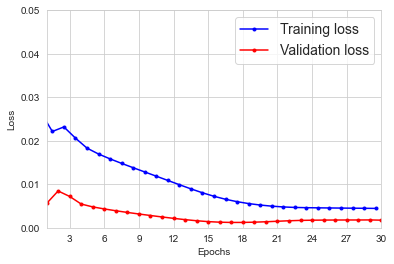

In [35]:
# Visualization of Training Loss and Validation Loss

def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, epochs, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(base_model_hist.history["loss"], base_model_hist.history["val_loss"])
plt.show()

In [36]:
mse_base_deep_rnn = base_model.evaluate(X_val_final, y_val)
rmse_base_deep_rnn = np.sqrt(mse_base_deep_rnn)

2022-04-03 23:20:03.978772: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 2s 48ms/step - loss: 0.0018 - mean_squared_error: 0.0018


In [37]:
y_pred_test_base = base_model.predict(X_test_final)
mae_base_deep_rnn_test = mean_absolute_error(y_test, y_pred_test_base)
evaluation_metrics.loc[1] = ['Base Deep RNN', 'Neuron=5, Timestep=5, Epoch=35, Multi Layers', mse_base_deep_rnn[0], rmse_base_deep_rnn[0], mae_base_deep_rnn_test]
evaluation_metrics

2022-04-03 23:20:07.877754: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


,Model,Details,MSE,RMSE,MAE(Test)
0,Naive Forecasting,Difference of Last Value in X val with y val,0.033607,0.183322,0.092275
1,Base Deep RNN,"Neuron=5, Timestep=5, Epoch=35, Multi Layers",0.001754,0.041880,0.034812


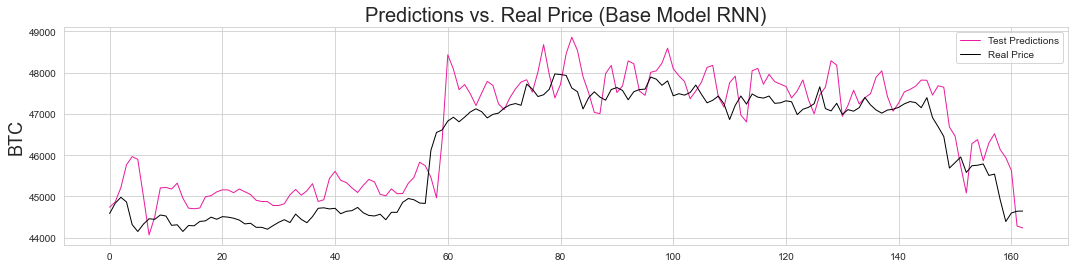

In [38]:
y_test_real = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_test_base = scaler.inverse_transform(y_pred_test_base)
fig, ax = plt.subplots(figsize=(18, 4), sharex=True)

plt.title("Predictions vs. Real Price (Base Model RNN)", fontsize=20)
plt.ylabel('BTC', fontsize=18)
plt.plot(y_pred_test_base, color="#E91D9E", linewidth=1.0)
plt.plot(y_test_real, color="black", linewidth=1.0)
plt.legend(["Test Predictions", "Real Price"], loc="upper right")

# valid.loc[valid["Difference"] >= 0, 'diff_color'] = "#2BC97A"
# valid.loc[valid["Difference"] < 0, 'diff_color'] = "#C92B2B"
# plt.bar(valid.index, valid["Difference"], width=0.8, color=valid['diff_color'])

plt.show()

## **9. Model Improvement**

### 9.1. Improved Recurrent Neural Network

In [39]:
deep_base = Sequential()

n_neurons = X_train_final.shape[1] * X_train_final.shape[2]
print('timesteps: ' + str(X_train_final.shape[1]) + ',' + ' features: ' + str(X_train_final.shape[2]) + ', neurons: ' + str(n_neurons))

# Model

deep_base.add(layers.SimpleRNN(5, return_sequences=True, input_shape=(None, X_train_final.shape[2])))
deep_base.add(layers.SimpleRNN(5, return_sequences=True))
deep_base.add(layers.SimpleRNN(2))
deep_base.add(layers.Dense(1, activation='linear'))
 
# Hyperparameters
optimizer='adam'; loss='mean_squared_error'; epochs = 40; batch_size = 128; patience = 6;

deep_base.compile(optimizer=optimizer, loss=loss, metrics=['mean_squared_error'])

deep_base.summary()

timesteps: 5, features: 1, neurons: 5
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_3 (SimpleRNN)    (None, None, 5)           35        
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, None, 5)           55        
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 2)                 16        
                                                                 
 dense (Dense)               (None, 1)                 3         
                                                                 
Total params: 109
Trainable params: 109
Non-trainable params: 0
_________________________________________________________________


In [40]:
deep_model_hist = deep_base.fit(
                    train_dataset,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=val_dataset,
                    verbose=0
                )

2022-04-03 23:20:11.086886: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-03 23:20:17.579631: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


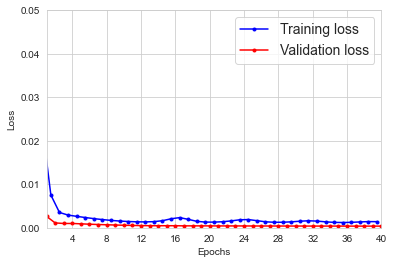

In [41]:
# Visualization of Training Loss and Validation Loss

plot_learning_curves(deep_model_hist.history["loss"], deep_model_hist.history["val_loss"])
plt.show()

In [42]:
mse_imp_deep_rnn = deep_base.evaluate(X_val_final, y_val)
rmse_imp_deep_rnn = np.sqrt(mse_imp_deep_rnn)

 1/32 [..............................] - ETA: 11s - loss: 2.0766e-04 - mean_squared_error: 2.0766e-04

2022-04-03 23:23:22.312232: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 16ms/step - loss: 3.8627e-04 - mean_squared_error: 3.8627e-04


In [43]:
y_pred_imp_deep = deep_base.predict(X_test_final)
mae_imp_deep_rnn_test = mean_absolute_error(y_test, y_pred_imp_deep)
evaluation_metrics.loc[2] = ['Improved Deep RNN - Dense Output', 'Neuron=5, Timestep=5, Epoch=50, Batch_size=128, Multi Layers', mse_imp_deep_rnn[0], rmse_imp_deep_rnn[0], mae_imp_deep_rnn_test]
evaluation_metrics

2022-04-03 23:23:23.306964: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


,Model,Details,MSE,RMSE,MAE(Test)
0,Naive Forecasting,Difference of Last Value in X val with y val,0.033607,0.183322,0.092275
1,Base Deep RNN,"Neuron=5, Timestep=5, Epoch=35, Multi Layers",0.001754,0.041880,0.034812
2,Improved Deep RNN - Dense Output,"Neuron=5, Timestep=5, Epoch=50, Batch_size=128...",0.000386,0.019654,0.018657


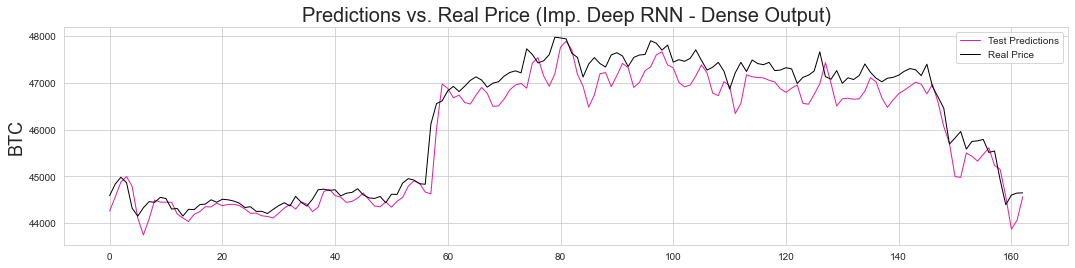

In [44]:
y_pred_imp_deep = scaler.inverse_transform(y_pred_imp_deep)

# plot prediction vs real price
fig, ax = plt.subplots(figsize=(18, 4), sharex=True)

plt.title("Predictions vs. Real Price (Imp. Deep RNN - Dense Output)", fontsize=20)
plt.ylabel('BTC', fontsize=18)
plt.plot(y_pred_imp_deep, color="#E91D9E", linewidth=1.0)
plt.plot(y_test_real, color="black", linewidth=1.0)
plt.legend(["Test Predictions", "Real Price"], loc="upper right")
plt.show()

### 9.2. LSTM Recurrent Neural Network

#### 9.2.1. With Tensor Pipeline

In [45]:
lstm_imp_model = Sequential()

n_neurons = X_train_final.shape[1] * X_train_final.shape[2]
print('timesteps: ' + str(X_train_final.shape[1]) + ',' + ' features: ' + str(X_train_final.shape[2]) + ', neurons: ' + str(n_neurons))

# The lstm_imp_model
lstm_imp_model.add(LSTM(5, return_sequences=True, input_shape=(None, X_train_final.shape[2]))) 
lstm_imp_model.add(LSTM(2))
lstm_imp_model.add(Dense(1, activation='linear'))
 
# Hyperparameters
optimizer='adam'; loss='mean_squared_error'; epochs = 75; patience = 6;
parameter_list = ['epochs ' + str(epochs), 'batch_size ' + str(batch_size), 'patience ' + str(patience), 'optimizer ' + str(optimizer), 'loss ' + str(loss)]
print('Parameters: ' + str(parameter_list))

lstm_imp_model.compile(optimizer=optimizer, loss=loss, metrics=['mean_squared_error'])

lstm_imp_model.summary()

timesteps: 5, features: 1, neurons: 5
Parameters: ['epochs 75', 'batch_size 128', 'patience 6', 'optimizer adam', 'loss mean_squared_error']
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 5)           140       
                                                                 
 lstm_1 (LSTM)               (None, 2)                 64        
                                                                 
 dense_1 (Dense)             (None, 1)                 3         
                                                                 
Total params: 207
Trainable params: 207
Non-trainable params: 0
_________________________________________________________________


In [46]:
lstm_imp_model_hist = lstm_imp_model.fit(
                    train_dataset,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=val_dataset,
                    verbose=0
                )

2022-04-03 23:23:28.121970: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-03 23:23:28.371345: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-03 23:23:28.485401: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-03 23:23:28.564763: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-03 23:23:28.783969: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-03 23:23:29.879506: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-03 23:23:29.955005: I tensorflow/core/grappler/optimizers/cust

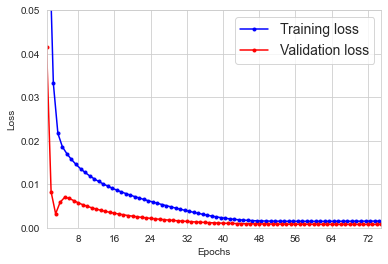

In [47]:
# Visualization of Training Loss and Validation Loss

plot_learning_curves(lstm_imp_model_hist.history["loss"], lstm_imp_model_hist.history["val_loss"])
plt.show()

In [48]:
mse_lstm_imp_rnn = lstm_imp_model.evaluate(X_val_final, y_val)
rmse_lstm_imp_rnn = np.sqrt(mse_lstm_imp_rnn)

2022-04-03 23:24:23.431673: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-03 23:24:23.996495: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 4/32 [==>...........................] - ETA: 0s - loss: 3.4568e-04 - mean_squared_error: 3.4568e-04 

2022-04-03 23:24:24.258690: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 2s 13ms/step - loss: 7.6789e-04 - mean_squared_error: 7.6789e-04


In [49]:
y_pred_lstm_pipe = lstm_imp_model.predict(X_test_final)
mae_lstm_imp_rnn_test = mean_absolute_error(y_test, y_pred_lstm_pipe)
evaluation_metrics.loc[3] = ['LSTM - Pipeline Dataset', 'Neuron=5, Timestep=5, Epoch=75, Batch_size=128, Multi Layers', mse_lstm_imp_rnn[0], rmse_lstm_imp_rnn[0], mae_lstm_imp_rnn_test]
evaluation_metrics

2022-04-03 23:24:25.479586: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-03 23:24:25.558254: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-03 23:24:25.626267: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


,Model,Details,MSE,RMSE,MAE(Test)
0,Naive Forecasting,Difference of Last Value in X val with y val,0.033607,0.183322,0.092275
1,Base Deep RNN,"Neuron=5, Timestep=5, Epoch=35, Multi Layers",0.001754,0.041880,0.034812
2,Improved Deep RNN - Dense Output,"Neuron=5, Timestep=5, Epoch=50, Batch_size=128...",0.000386,0.019654,0.018657
3,LSTM - Pipeline Dataset,"Neuron=5, Timestep=5, Epoch=75, Batch_size=128...",0.000768,0.027711,0.016086


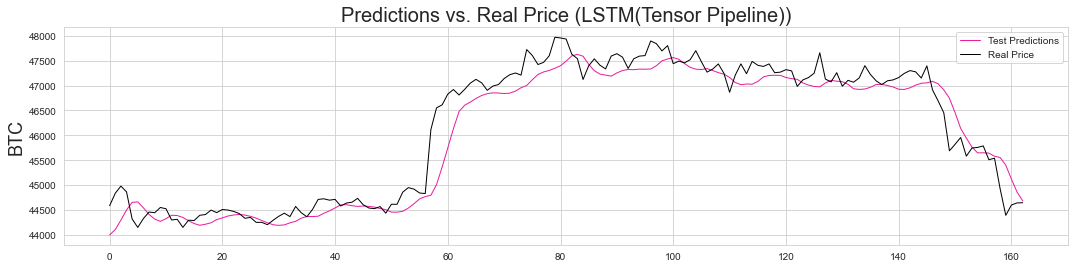

In [50]:
y_pred_lstm_pipe = scaler.inverse_transform(y_pred_lstm_pipe)
# plot prediction vs real price
fig, ax = plt.subplots(figsize=(18, 4), sharex=True)

plt.title("Predictions vs. Real Price (LSTM(Tensor Pipeline))", fontsize=20)
plt.ylabel('BTC', fontsize=18)
plt.plot(y_pred_lstm_pipe, color="#E91D9E", linewidth=1.0)
plt.plot(y_test_real, color="black", linewidth=1.0)
plt.legend(["Test Predictions", "Real Price"], loc="upper right")
plt.show()

#### 9.2.2. Without Tensor Pipeline

- Karena tampaknya LSTM dan model model sebelumnya tidak memiliki hasil prediksi yang baik, maka kita akan mencoba melatih model dengan data yang tanpa sebelum dijadikan data tensor (tanpa pipeline)

In [51]:
lstm_imp_model_2 = Sequential()

n_neurons = X_train_final.shape[1] * X_train_final.shape[2]
print('timesteps: ' + str(X_train_final.shape[1]) + ',' + ' features: ' + str(X_train_final.shape[2]) + ', neurons: ' + str(n_neurons))

# The lstm_imp_model_2
lstm_imp_model_2.add(LSTM(5, return_sequences=True, input_shape=(None, X_train_final.shape[2]))) 
lstm_imp_model_2.add(LSTM(2))
lstm_imp_model_2.add(Dense(1, activation='linear'))

# Hyperparameters
optimizer='adam'; loss='mean_squared_error'; epochs = 75; patience = 6;
parameter_list = ['epochs ' + str(epochs), 'batch_size ' + str(batch_size), 'patience ' + str(patience), 'optimizer ' + str(optimizer), 'loss ' + str(loss)]
print('Parameters: ' + str(parameter_list))

lstm_imp_model_2.compile(optimizer=optimizer, loss=loss, metrics=['mean_squared_error'])

lstm_imp_model_2.summary()

timesteps: 5, features: 1, neurons: 5
Parameters: ['epochs 75', 'batch_size 128', 'patience 6', 'optimizer adam', 'loss mean_squared_error']
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, None, 5)           140       
                                                                 
 lstm_3 (LSTM)               (None, 2)                 64        
                                                                 
 dense_2 (Dense)             (None, 1)                 3         
                                                                 
Total params: 207
Trainable params: 207
Non-trainable params: 0
_________________________________________________________________


In [52]:
lstm_imp_model_hist_2 = lstm_imp_model_2.fit(
                    X_train_final,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_val_final, y_val),
                    verbose=0
                )

2022-04-03 23:24:30.200211: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-03 23:24:30.464732: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-03 23:24:30.560013: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-03 23:24:30.657488: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-03 23:24:30.815924: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-03 23:24:32.465726: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-03 23:24:32.647770: I tensorflow/core/grappler/optimizers/cust

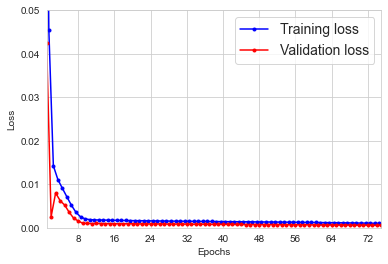

In [53]:
# Visualization of Training Loss and Validation Loss

plot_learning_curves(lstm_imp_model_hist_2.history["loss"], lstm_imp_model_hist_2.history["val_loss"])
plt.show()

In [54]:
mse_lstm_imp_rnn_2 = lstm_imp_model_2.evaluate(X_val_final, y_val)
rmse_lstm_imp_rnn_2 = np.sqrt(mse_lstm_imp_rnn_2)

32/32 [==============================] - 1s 10ms/step - loss: 5.6047e-04 - mean_squared_error: 5.6047e-04


In [55]:
y_pred_lstm_non = lstm_imp_model_2.predict(X_test_final)
mae_lstm_imp_rnn_2_test = mean_absolute_error(y_test, y_pred_lstm_non)
evaluation_metrics.loc[4] = ['LSTM - Non-Pipeline Dataset', 'Without tensorflow pipeline dataset. The rest is same', mse_lstm_imp_rnn_2[0], rmse_lstm_imp_rnn_2[0], mae_lstm_imp_rnn_2_test]
evaluation_metrics

2022-04-03 23:25:41.982570: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-03 23:25:42.066685: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-03 23:25:42.153286: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


,Model,Details,MSE,RMSE,MAE(Test)
0,Naive Forecasting,Difference of Last Value in X val with y val,0.033607,0.183322,0.092275
1,Base Deep RNN,"Neuron=5, Timestep=5, Epoch=35, Multi Layers",0.001754,0.041880,0.034812
2,Improved Deep RNN - Dense Output,"Neuron=5, Timestep=5, Epoch=50, Batch_size=128...",0.000386,0.019654,0.018657
3,LSTM - Pipeline Dataset,"Neuron=5, Timestep=5, Epoch=75, Batch_size=128...",0.000768,0.027711,0.016086
4,LSTM - Non-Pipeline Dataset,Without tensorflow pipeline dataset. The rest ...,0.000560,0.023674,0.011872


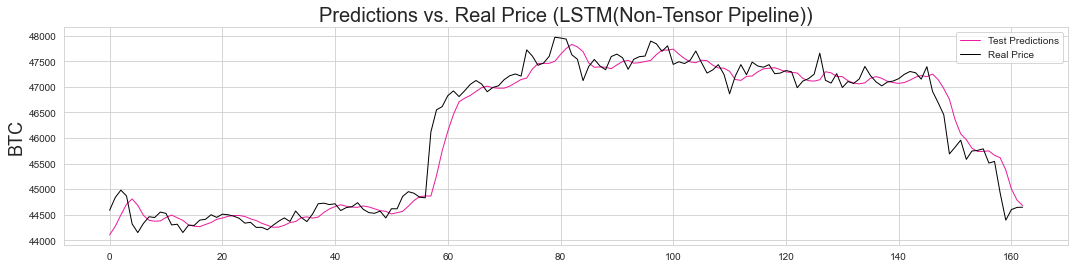

In [56]:
y_pred_lstm_non = scaler.inverse_transform(y_pred_lstm_non)
# plot prediction vs real price
fig, ax = plt.subplots(figsize=(18, 4), sharex=True)

plt.title("Predictions vs. Real Price (LSTM(Non-Tensor Pipeline))", fontsize=20)
plt.ylabel('BTC', fontsize=18)
plt.plot(y_pred_lstm_non, color="#E91D9E", linewidth=1.0)
plt.plot(y_test_real, color="black", linewidth=1.0)
plt.legend(["Test Predictions", "Real Price"], loc="upper right")
plt.show()

- Disini terlihat model memprediksi harga jauh lebih baik dibandingkan dengan model-model sebelumnya, harga yang diprediksi pun juga reaktif atau memiliki kenaikan atau turunan yang mengikuti pola harga aslinya, meskipun terlihat cenderung terdapat lagging pada harga yang diprediksi

### 9.3. GRU Recurrent Neural Network

In [57]:
gru_imp_model = Sequential()

n_neurons = X_train_final.shape[1] * X_train_final.shape[2]
print('timesteps: ' + str(X_train_final.shape[1]) + ',' + ' features: ' + str(X_train_final.shape[2]) + ', neurons: ' + str(n_neurons))

# The gru_imp_model
gru_imp_model.add(GRU(5, return_sequences=True, input_shape=(None, X_train_final.shape[2]))) 
gru_imp_model.add(GRU(2))
gru_imp_model.add(Dense(1, activation='linear'))
 
# Hyperparameters
optimizer='adam'; loss='mean_squared_error'; epochs = 75; patience = 6;
parameter_list = ['epochs ' + str(epochs), 'batch_size ' + str(batch_size), 'patience ' + str(patience), 'optimizer ' + str(optimizer), 'loss ' + str(loss)]
print('Parameters: ' + str(parameter_list))

gru_imp_model.compile(optimizer=optimizer, loss=loss, metrics=['mean_squared_error'])

early_stop = EarlyStopping(monitor='val_loss', 
                           patience=patience, 
                           verbose=0)

gru_imp_model.summary()

timesteps: 5, features: 1, neurons: 5
Parameters: ['epochs 75', 'batch_size 128', 'patience 6', 'optimizer adam', 'loss mean_squared_error']
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, None, 5)           120       
                                                                 
 gru_1 (GRU)                 (None, 2)                 54        
                                                                 
 dense_3 (Dense)             (None, 1)                 3         
                                                                 
Total params: 177
Trainable params: 177
Non-trainable params: 0
_________________________________________________________________


In [58]:
gru_imp_model_hist = gru_imp_model.fit(
                    X_train_final,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_val_final, y_val),
                    verbose=0
                )

2022-04-03 23:25:46.877692: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-03 23:25:47.145968: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-03 23:25:47.249065: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-03 23:25:47.343700: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-03 23:25:47.485643: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-03 23:25:48.777430: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-03 23:25:48.858821: I tensorflow/core/grappler/optimizers/cust

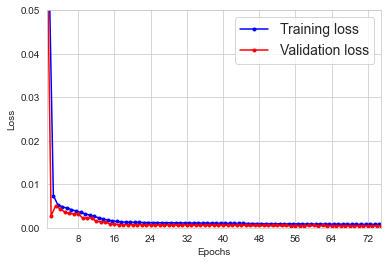

In [59]:
# Visualization of Training Loss and Validation Loss

plot_learning_curves(gru_imp_model_hist.history["loss"], gru_imp_model_hist.history["val_loss"])
plt.show()

In [60]:
mse_gru_imp_rnn = gru_imp_model.evaluate(X_val_final, y_val)
rmse_gru_imp_rnn = np.sqrt(mse_gru_imp_rnn)

32/32 [==============================] - 0s 10ms/step - loss: 4.6695e-04 - mean_squared_error: 4.6695e-04


In [61]:
y_pred_gru_non = gru_imp_model.predict(X_test_final)
mae_gru_imp_test = mean_absolute_error(y_test, y_pred_gru_non)
evaluation_metrics.loc[5] = ['GRU - Non-Pipeline Dataset', 'Without tensorflow pipeline dataset. The rest is same', mse_gru_imp_rnn[0], rmse_gru_imp_rnn[0], mae_gru_imp_test]
evaluation_metrics

2022-04-03 23:26:51.198142: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-03 23:26:51.363491: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-03 23:26:51.430520: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


,Model,Details,MSE,RMSE,MAE(Test)
0,Naive Forecasting,Difference of Last Value in X val with y val,0.033607,0.183322,0.092275
1,Base Deep RNN,"Neuron=5, Timestep=5, Epoch=35, Multi Layers",0.001754,0.041880,0.034812
2,Improved Deep RNN - Dense Output,"Neuron=5, Timestep=5, Epoch=50, Batch_size=128...",0.000386,0.019654,0.018657
3,LSTM - Pipeline Dataset,"Neuron=5, Timestep=5, Epoch=75, Batch_size=128...",0.000768,0.027711,0.016086
4,LSTM - Non-Pipeline Dataset,Without tensorflow pipeline dataset. The rest ...,0.000560,0.023674,0.011872
5,GRU - Non-Pipeline Dataset,Without tensorflow pipeline dataset. The rest ...,0.000467,0.021609,0.010356


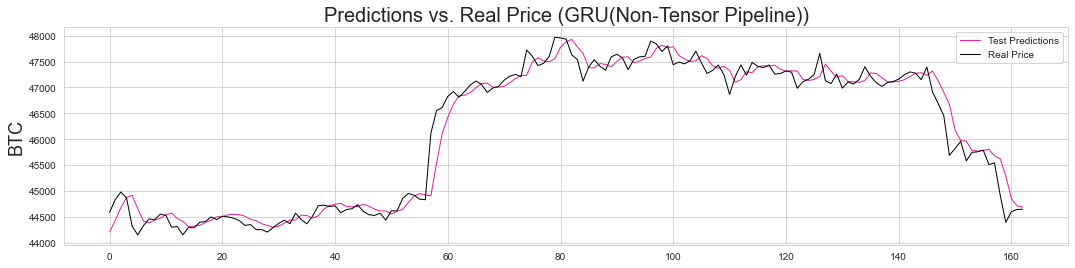

In [62]:
y_pred_gru_non = scaler.inverse_transform(y_pred_gru_non)

# plot prediction vs real price
fig, ax = plt.subplots(figsize=(18, 4), sharex=True)

plt.title("Predictions vs. Real Price (GRU(Non-Tensor Pipeline))", fontsize=20)
plt.ylabel('BTC', fontsize=18)
plt.plot(y_pred_gru_non, color="#E91D9E", linewidth=1.0)
plt.plot(y_test_real, color="black", linewidth=1.0)
plt.legend(["Test Predictions", "Real Price"], loc="upper right")
plt.show()

### 9.4 LSTM With 50 Time Step/Sequence Length

- Kita akan mencoba mengubah panjang time step menjadi 50, untuk mengetahui apakah model dapat memprediksi lebih baik jika memiliki informasi yang disimpan dalam dataset jauh lebih besar

In [63]:
sequence_length_2 = 50

def partition_dataset(sequence_length_2, data):
    x, y = [], []
    data_len = data.shape[0]

    for i in range(sequence_length_2, data_len):
        x.append(data[i-sequence_length_2:i,:]) 
        y.append(data[i, 0]) 
    
    x = np.array(x)
    y = np.array(y)
    return x, y
    
X_train_final_2, y_train_2 = partition_dataset(sequence_length_2, X_train_scaled)
X_val_final_2, y_val_2 = partition_dataset(sequence_length_2, X_val_scaled)
X_test_final_2, y_test_2 = partition_dataset(sequence_length_2, X_test_scaled)


In [64]:
lstm_24_seq = Sequential()

n_neurons = X_train_final.shape[1] * X_train_final.shape[2]
print('timesteps: ' + str(X_train_final.shape[1]) + ',' + ' features: ' + str(X_train_final.shape[2]) + ', neurons: ' + str(n_neurons))

# The lstm_24_seq
lstm_24_seq.add(LSTM(50, return_sequences=True, input_shape=(None, X_train_final.shape[2])))
lstm_24_seq.add(LSTM(5))
lstm_24_seq.add(Dense(1, activation='linear'))
 
# Hyperparameters
optimizer='adam'; loss='mean_squared_error'; epochs = 50; patience = 6;
parameter_list = ['epochs ' + str(epochs), 'batch_size ' + str(batch_size), 'patience ' + str(patience), 'optimizer ' + str(optimizer), 'loss ' + str(loss)]
print('Parameters: ' + str(parameter_list))

lstm_24_seq.compile(optimizer=optimizer, loss=loss, metrics=['mean_squared_error'])

lstm_24_seq.summary()

timesteps: 5, features: 1, neurons: 5
Parameters: ['epochs 50', 'batch_size 128', 'patience 6', 'optimizer adam', 'loss mean_squared_error']
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, None, 50)          10400     
                                                                 
 lstm_5 (LSTM)               (None, 5)                 1120      
                                                                 
 dense_4 (Dense)             (None, 1)                 6         
                                                                 
Total params: 11,526
Trainable params: 11,526
Non-trainable params: 0
_________________________________________________________________


In [65]:
lstm_24_seq_hist = lstm_24_seq.fit(
                    X_train_final_2,
                    y_train_2,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_val_final_2, y_val_2),
                    verbose=0
                )

2022-04-03 23:26:55.039667: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-03 23:26:55.560296: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-03 23:26:55.905545: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-03 23:26:56.223317: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-03 23:26:56.797818: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-03 23:27:00.483791: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-03 23:27:00.563208: I tensorflow/core/grappler/optimizers/cust

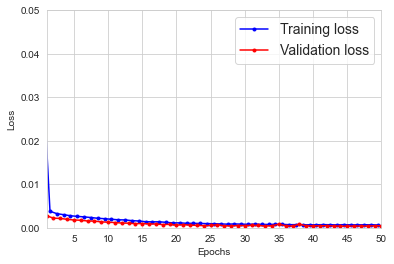

In [66]:
# Visualization of Training Loss and Validation Loss

plot_learning_curves(lstm_24_seq_hist.history["loss"], lstm_24_seq_hist.history["val_loss"])
plt.show()

In [67]:
mse_lstm_24_seq = lstm_24_seq.evaluate(X_val_final_2, y_val_2)
rmse_lstm_24_seq = np.sqrt(mse_lstm_24_seq)

30/30 [==============================] - 1s 30ms/step - loss: 4.7736e-04 - mean_squared_error: 4.7736e-04


In [68]:
y_pred_lstm_24 = lstm_24_seq.predict(X_test_final_2)
mae_lstm_24_seq = mean_absolute_error(y_test_2, y_pred_lstm_24)
evaluation_metrics.loc[6] = ['LSTM - 50 Sequence Length', 'Timestep=50, without tensorflow pipeline dataset. The rest is same', mse_lstm_24_seq[0], rmse_lstm_24_seq[0], mae_lstm_24_seq]
evaluation_metrics

2022-04-03 23:28:55.303701: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-03 23:28:55.385900: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-03 23:28:55.528334: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


,Model,Details,MSE,RMSE,MAE(Test)
0,Naive Forecasting,Difference of Last Value in X val with y val,0.033607,0.183322,0.092275
1,Base Deep RNN,"Neuron=5, Timestep=5, Epoch=35, Multi Layers",0.001754,0.041880,0.034812
2,Improved Deep RNN - Dense Output,"Neuron=5, Timestep=5, Epoch=50, Batch_size=128...",0.000386,0.019654,0.018657
3,LSTM - Pipeline Dataset,"Neuron=5, Timestep=5, Epoch=75, Batch_size=128...",0.000768,0.027711,0.016086
4,LSTM - Non-Pipeline Dataset,Without tensorflow pipeline dataset. The rest ...,0.000560,0.023674,0.011872
5,GRU - Non-Pipeline Dataset,Without tensorflow pipeline dataset. The rest ...,0.000467,0.021609,0.010356
6,LSTM - 50 Sequence Length,"Timestep=50, without tensorflow pipeline datas...",0.000477,0.021848,0.013480


- MSE pada validation set maupun MAE pada Training set mendapatkan nilai loss yang lebih kecil jika dibandingkan dengan model yang sama namun memiliki sequence atau time step yang lebih pendek

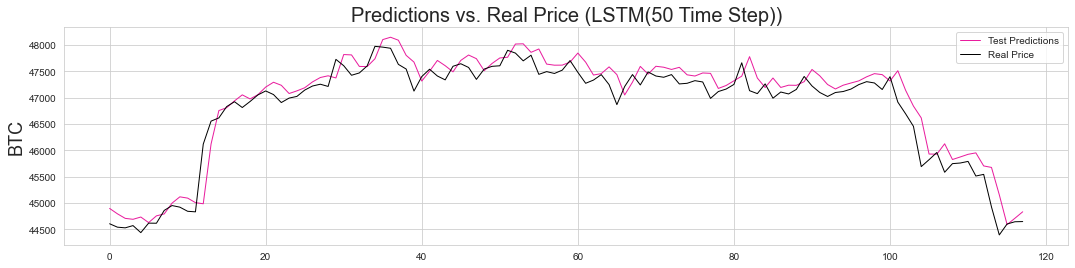

In [69]:
y_pred_lstm_24 = scaler.inverse_transform(y_pred_lstm_24)
y_test_2_real = scaler.inverse_transform(y_test_2.reshape(-1, 1))

# plot prediction vs real price
fig, ax = plt.subplots(figsize=(18, 4), sharex=True)

plt.title("Predictions vs. Real Price (LSTM(50 Time Step))", fontsize=20)
plt.ylabel('BTC', fontsize=18)
plt.plot(y_pred_lstm_24, color="#E91D9E", linewidth=1.0)
plt.plot(y_test_2_real, color="black", linewidth=1.0)
plt.legend(["Test Predictions", "Real Price"], loc="upper right")
plt.show()

- Model juga terlihat memprediksi harga lebih mendekati dengan harga aslinya jika kita bandingkan dengan model-model sebelumnya

### 9.5. Evaluasi Nilai SME LSTM & GRU LSTM 5 Seq

In [70]:
print(np.mean(np.abs(y_test_real - y_pred_lstm_non)))

191.195132285276


In [71]:
print(np.mean(np.abs(y_test_real - y_pred_lstm_non)/y_test_real)*100)

0.4142831810112337


In [72]:
print(np.mean(np.abs(y_test_real - y_pred_gru_non)))

166.7881019938649


In [73]:
print(np.mean(np.abs(y_test_real - y_pred_gru_non)/y_test_real)*100)

0.36160964040658666


### 9.6. Evaluasi Nilai LSTM 50 Seq

In [74]:
print(np.mean(np.abs(y_test_2_real - y_pred_lstm_24)))

217.1039777542372


In [75]:
print(np.mean(np.abs(y_test_2_real - y_pred_lstm_24)/y_test_2_real)*100)

0.46559850283453247


## **10. Model Saving**

### 10.1. Choose The Best Model

In [76]:
y_dummy_price = []
for i in range(0, 45):
    y_dummy_price.append(43000)
    
y_pred_lstm_24_compare = y_pred_lstm_24
y_pred_lstm_24_compare = np.insert(y_pred_lstm_24_compare, 0, np.array(y_dummy_price).reshape(-1,1), axis=0)

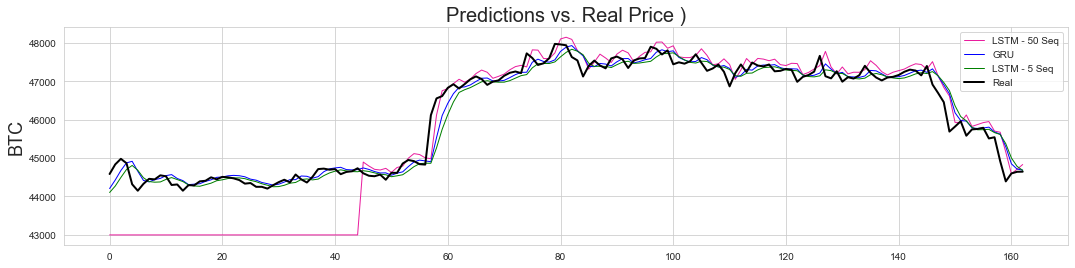

In [77]:
# plot prediction vs real price
fig, ax = plt.subplots(figsize=(18, 4), sharex=True)

plt.title("Predictions vs. Real Price )", fontsize=20)
plt.ylabel('BTC', fontsize=18)
plt.plot(y_pred_lstm_24_compare, color="#E91D9E", linewidth=1.0)
plt.plot(y_pred_gru_non, color="blue", linewidth=1.0)
plt.plot(y_pred_lstm_non, color="green", linewidth=1.0)
plt.plot(y_test_real, color="black", linewidth=2.0)
plt.legend(["LSTM - 50 Seq", "GRU", "LSTM - 5 Seq", "Real"], loc="upper right")
plt.show()

- Pada hasil evaluasi MAE dan MSE sebelumnya, model LSTM dengan 50 Sequence length mendapatkan hasil untuk MAE(Validation set)=0.000038 dan untuk MAE(Test set)=0.003703 yang menandakan model ini berperforma lebih baik secara keseluruhan jika dibandingkan dengan model-model sebelumnya.
- Dari perbandingkan plot diatas, terlihat LSTM- 50 Sequence length(garis berwarna pink) memiliki posisi prediksi harga yang lebih dekat dengan harga aslinya jika dibandingkan model yang sama-sama memiiki performa baik

- Dengan pertimbangan ini kita menetapkan bahwa model `LSTM-50 Sequence Length` akan kita gunakan sebagai model yang memprediksi data baru(inference) baik pada notebook ini ataupun


### 10.2. Scaling Pipeline

In [78]:
with open("save_models/scale_pipe.pkl", "wb") as f:
    pickle.dump(scaler, f)

### 10.3. Save Deep Learning Model

In [79]:
# save model
lstm_24_seq.save('save_models/lstm_24.h5')
print('Model Saved!')

Model Saved!


In [80]:
# save model
gru_imp_model.save('save_models/gru_5.h5')
print('Model Saved!')

Model Saved!


## **11. Model Inference**

In [81]:
df_inf = pd.read_csv('inference/BTCUSDT-1h-2022-02.csv', header=None)

In [82]:
# df_inf[0] = pd.to_datetime(df_inf[0],unit='ms')
# df_inf[6] = pd.to_datetime(df_inf[6],unit='ms')

row_inf = 7 * 24
# kolom close di index ke-4
df_inf_selected = df_inf[:row_inf].iloc[:, 4]   

In [83]:
from tensorflow.keras.models import load_model
# load scaling preprocessing
with open("scale_pipe.pkl", "rb") as f:
    pipeline = pickle.load(f)

# load deep learning model
lstm_24_seq_load = load_model('lstm_24.h5')


FileNotFoundError: [Errno 2] No such file or directory: 'scale_pipe.pkl'

In [ ]:
df_inf_scaled = pipeline.transform(df_inf_selected.values.reshape(-1, 1))

In [ ]:
sequence_length = 50

def partition_dataset_inf(sequence_length, data):
    x = []
    y = []
    data_len = data.shape[0]

    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) 
        y.append(data[i,:])

    x = np.array(x)
    y = np.array(y)
    return x, y

In [ ]:
df_inf_scaled, y_inf_scaled = partition_dataset_inf(sequence_length, df_inf_scaled)

In [ ]:
y_pred_inf = lstm_24_seq_load.predict(df_inf_scaled)

2022-04-03 04:32:22.238590: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-03 04:32:22.337367: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-03 04:32:22.536402: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


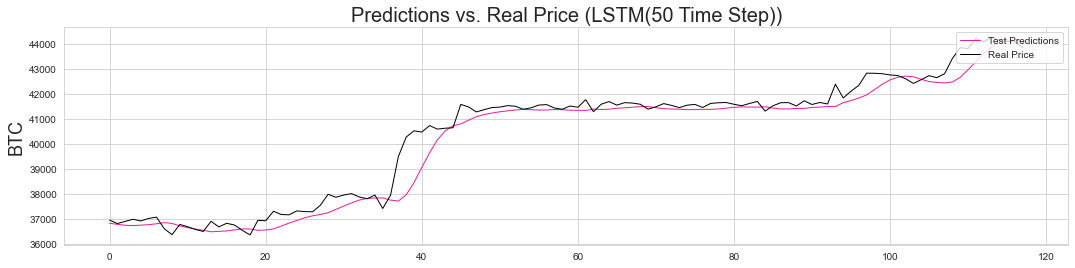

In [ ]:
y_pred_inf_real = pipeline.inverse_transform(y_pred_inf)
y_inf_real = pipeline.inverse_transform(y_inf_scaled)
# plot prediction vs real price
fig, ax = plt.subplots(figsize=(18, 4), sharex=True)

plt.title("Predictions vs. Real Price (LSTM(50 Time Step))", fontsize=20)
plt.ylabel('BTC', fontsize=18)
plt.plot(y_pred_inf_real, color="#E91D9E", linewidth=1.0)
plt.plot(y_inf_real, color="black", linewidth=1.0)
plt.legend(["Test Predictions", "Real Price"], loc="upper right")
plt.show()

- Kita akan mencoba memprediksi harga dengan menambahkan satu data baru, yang dimana dari informasi data sebelumnya ditambah dengan data ini, berapakah harga yang akan diprediksi oleh model

In [ ]:
df_inf_selected[len(df_inf_selected)+1] = 44500

In [ ]:
df_inf_scaled = pipeline.transform(df_inf_selected.values[len(df_inf_selected)-50:].reshape(-1, 1))

In [ ]:
df_inf_scaled = df_inf_scaled.reshape(-1, 50, 1)

In [ ]:
y_pred_inf = lstm_24_seq_load.predict(df_inf_scaled)
y_pred_inf_s = pipeline.inverse_transform(y_pred_inf)
print(f"Prediksi Harga Penutupan Bitcoin Satu Jam Kedepan: ${scaler.inverse_transform(y_pred_inf)[0][0]}")

Prediksi Harga Penutupan Bitcoin Satu Jam Kedepan: $43982.5546875


In [ ]:
df_real = scaler.inverse_transform(df_inf_scaled.reshape(1,-1))

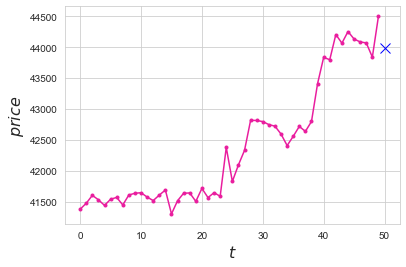

In [ ]:
# Visualization of the First Three Data

def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$price$"):
    plt.plot(series, ".-", color="#E91D9E")
    if y is not None:
        plt.plot(50, y, "bx", markersize=10, color="blue")
    if y_pred is not None:
        plt.plot(50, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16,)
    if y_label:
        plt.ylabel(y_label, fontsize=16)

plot_series(df_real.reshape(-1), y_pred_inf_s[0][0])

- Ternyata harga yang diprediksi ialah $44385.55 yang berarti harga bergerak turun dari harga sebelumnya. Karena hal ini, kita tidak akan melakukan posisi `Open Trade`

<hr>

## **11. Conclusion**

Dari sisi model:
- Kita telah berhasil membuat berbagai macam model dimana kita memilih model `LSTM - 50 Sequence Length` sebagai model terbaik dan akan digunakan sebagai model yang akan memprediksi harga terkini

Dari sisi dataset:
- Pergerakan harga BTC cenderung bergerak dengan alasan-alasan fundamental yang mendasarinya seperti entah berita baik ataupun berita buruk yang terjadi
- BTC terlihat memiliki volatilitas yang tinggi dimana nilai terlihat dari varians/std-nya cukup tinggi

Pengembangan lebih lanjut:
- Dengan mengetahui bahwa pergerakan BTC juga dipengaruhi oleh sentimen-sentimen yang terjadi khususnya pada komunitas cryptocurrency, nampaknya akan dijadikan sebuah pertimbangan dengan memasukan analisis sebagai salah satu penentu prediksi pergerakan harga BTC
- Time Frame yang lebih bervariasi(1 hari, 1 bulan ataupun bahkan 5 menit) juga dapat dimasukkan untuk mengembangkan model lainnya yang disesuaikan dengan jenis atau cara trading yang dilakukan oleh tiap-tiap individu